# Filteri

Filteri, kao što im ime kaže, omogućavaju filtriranje informacija koje nose signali. U zavisnosti od zadataka na kojima radimo, možemo ih primenjivati u vremenskom (ili prostornom) domenu ili u frekvencijskom domenu.

Na uvodnom času smo videli primer filtera u frekvencijskom domenu. Prvo smo nad signalom izvršili Furijeovu transformaciju, zatim smo odsekli željene frekvencije, a potom primenili inverznu Furijeovu transformaciju kako bi se vratili u vremenski domen. __U praksi se ipak, zbog brzine i primene u realnom vremenu češće koriste filteri u vremenskom domenu.__ U primeru koji sledi videćemo primer jednog takvog filtera. Kreiraćemo niskopropusni FIR filter koji će modifikovati naš ulazni signal. U implementaciji ćemo koristiti paket `signal` biblioteke `scipy` koji nam stavlja na raspolaganje mnogobrojne funkcije za rad sa signalima. 

In [3]:
from scipy import signal

In [4]:
import numpy as np
from matplotlib import pyplot as plt

Podsetimo se da su niskopropusni filteri (engl. lowpass filters) filteri koji propuštaju frekvencije manje od zadate tj. odsecaju frekvencije veće od zadate. Ova granična frekvencija se zove frekvencija odsecanja (engl. cutoff frequency). Idealni frekvencijski odgovor niskopropusnog filtera bi izgladao ovako: <img src='assets/ideal_lowpass_filter.png'>

U praksi je idealni filter moguće samo aproksimirati pa je realna slika frekvencijskog odgovora zapravo ovakva: <img src='assets/FIR_filter.png'>

Prelaz između frekvencija nije nagli već ga prati tranzicioni opseg (engl. transition width). Deo pre i deo posle tranzicionog opsega se zovu, redom, propusni opseg (engl. passband) i zaustavni opseg (engl. stopband). Takođe, amplituda signala nakon frekvencije odsecanja nije nula već ima neko odstupanje koje se fizički može opaziti kroz prisustvo talasanja (engl. ripple). Slično talasanje se može primetiti i u propusnom opsegu. 

Dužina tranzicionog opsega, kao i odstupanja amplituda se zadaju kao ulazni parametri funkcija koje kreiraju filtere. 

Podsetimo se i da su FIR filteri filteri kod kojih izlazna vrednost signala zavisi samo od prethodnih vrednosti signala. Ako sa $x_i$ obeležimo ulazne vrednosti signala, a sa $y_i$ izlazne vrednosti signala zakonitost koja ih povezuje je $y_n=\sum_{k=0}^{M}{b_k\cdot x_{n-k}}$ gde $b_k$ predstavljaju koeficijente filtera, a $M$ takozvani red filtera, odnosno broj prethodnih ulaznih vrednosti signala koje se koriste za izračunavanje izlazne vrednosti. Ovo je zapravo izraz kojim se računa diskretna konvolucija dva signala, ulaznog signala i signala kojim se predstavlja filter.

Funkcija `signal.firwin` se koristi za kreiranje FIR filtera prozorskom metodom. Ova metoda polazeći od neke prozorske funkcije na osnovu parametara koji se zadaju kreira odgovarajuće predefinisane signale. Parametri su broj tačaka koje filter uključuje (parametar `numtaps`), frekvencija odsecanja (parametar `cutoff`) i tip prozorske funkcije koja će se koristiti za kreiranje filtera (parametar `window`). Rezultat funkcije su koeficijenti $b_i$ koji se dalje koriste u diskretnoj konvoluciji.

U primeru ćemo posmatrati signal određen jednačinom x(t) čijim je uzorkovanjem frekvencijom od 100Hz dobijeno 400 uzoraka. 

In [5]:
Fs = 100
N = 400

In [6]:
t = np.arange(N) / Fs
x = np.cos(2*np.pi*0.5*t) + 0.2*np.sin(2*np.pi*2.5*t+0.1) + 0.2*np.sin(2*np.pi*15.3*t) + 0.1*np.sin(2*np.pi*16.7*t + 0.1) + 0.1*np.sin(2*np.pi*23.45*t+.8)

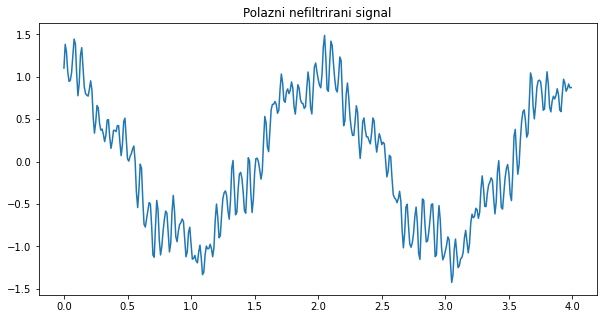

In [7]:
plt.figure(figsize=(10, 5))
plt.title('Polazni nefiltrirani signal')
plt.plot(t, x)

plt.show()

Najveća vrednost frekvencije, po Najkvistovoj teoremi, prisutna u signalu je polovina frekvencije uzorkovanja. Ova frekvencija se zove granična ili Najkvistova frekvencija.

In [8]:
nyquist_frequency = Fs/2

Neka dalje željena dužina tranzicije bude 5Hz. Praksa je da se ova dužina zadaje relativno u odnosu na Najkvistovu frekvenciju tako da se dobija grafik sa normalizovanim frekvencijama duž x-ose (na skali od 0 do 1).

In [9]:
width = 5.0/nyquist_frequency

Neka dozvoljeno odstupanje magnitude u zaustavnom delu bude 60 dB.

In [10]:
ripple = 60.0

Za kreiranje filtera koristićemo Kasijerov prozor. Za prosleđene vrednosti dozvoljenog odstupanja i dužinu tranzicije, funkcija `kasierord` izračunaće red prozorske funkcije i njene koeficijente. Postoje ugraćene funkcije i za rad sa drugim prozorskim funkcijama.

In [11]:
M, beta = signal.kaiserord(ripple, width)

Neka frekvencija odsecanja filtera bude 10Hz.

In [12]:
cutoff = 10

Dalje, nad ovim vrednostima možemo kreirati željeni filter pomoću funkcije `firwin`.

In [13]:
taps = signal.firwin(M, cutoff/nyquist_frequency, window=('kaiser', beta))

Ovako kreirani filter možemo iskoristiti kao niskopropusni filter za filtriranje polaznog signala pomoću funkcije `lfilter`. 

In [14]:
filtered_x = signal.lfilter(taps, 1.0, x)

Možemo da prikažemo kako izgledaju koeficijenti filtera. 

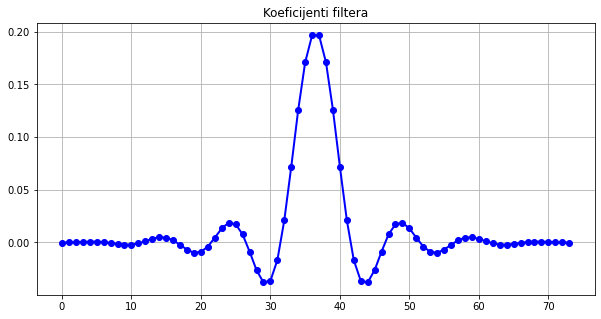

In [16]:
plt.figure(figsize=(10, 5))
plt.title('Koeficijenti filtera')
plt.plot(taps, 'bo-', linewidth=2)
plt.grid(True)

Možemo da prikažemo i kako izgleda frekvencijski odgovor kreiranog filtera.

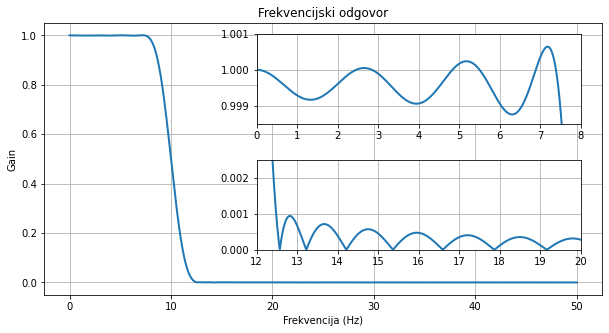

In [18]:
plt.figure(figsize=(10, 5))

# Frekvencijski odgovor filtera sa prilagođenim (nenormalizovanim) skalama 
# Funkcija freqz izračunava odgovarajući frekvencijski odgovor filtera
w, h = signal.freqz(taps, worN=8000)
plt.plot((w/np.pi)*nyquist_frequency, np.abs(h), linewidth=2)
plt.xlabel('Frekvencija (Hz)')
plt.ylabel('Gain')
plt.title('Frekvencijski odgovor')
plt.ylim(-0.05, 1.05)
plt.grid(True)

# Uvećani frekvencijski odgovor na intervalu [0Hz, 8Hz] kako bi se videli talasici u propusnom delu
ax1 = plt.axes([0.42, 0.6, .45, .25])
plt.plot((w/np.pi)*nyquist_frequency, np.absolute(h), linewidth=2)
plt.xlim(0,8.0)
plt.ylim(0.9985, 1.001)
plt.grid(True)

# Uvećani frekvencijski odgovor na intervalu [12Hz, 20Hz] kako bi se videli talasici u zaustavnom delu
ax2 = plt.axes([0.42, 0.25, .45, .25])
plt.plot((w/np.pi)*nyquist_frequency, np.absolute(h), linewidth=2)
plt.xlim(12.0, 20.0)
plt.ylim(0.0, 0.0025)
plt.grid(True)

I konačno, možemo prikazati kako izgleda filtrirani signal.

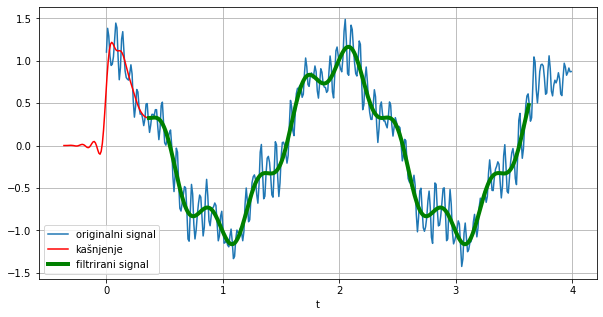

In [19]:
plt.figure(figsize=(10, 5))

# Izračunavamo kašnjenje signala tj. vreme koje je potrebno da se generiše M-1 uzorak
delay = 0.5 * (M-1) / Fs

# Crtamo originalni signal 
plt.plot(t, x, label='originalni signal')

# Crtamo deo filtriranog signala pomerenog za vreme kašnjenja
plt.plot(t-delay, filtered_x, 'r-', label='kašnjenje')

# Crtamo filtrirani signal
plt.plot(t[M-1:]-delay, filtered_x[M-1:], 'g', linewidth=4, label='filtrirani signal')

plt.xlabel('t')
plt.grid(True)
plt.legend(loc='best')
plt.show()

Za vežbu se možemo uveriti da filtrirani signal odgovara signalu $np.cos(2*np.pi*0.5*t) + 0.2*np.sin(2*np.pi*2.5*t+0.1)$ tj. signalu iz kojeg su uklonjeni faktori sa frekvencijom većom od 10Hz. 